In [1]:
from qutip import *
import math as math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scipy as scipy
import matplotlib.animation as animation
from tqdm import tqdm
import sys
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import os
from src import *

In [2]:
N = 100
g_0 = 0.01
n_q = 150 # Photon saturation number
C = np.linspace(1e-15,2,30) # Cooperativity
k = g_0*np.sqrt(2/(C*n_q)) # Photon loss
P = 2*n_q*k # Pumping
delta = 0 # Detuning

In [3]:
g = basis(2,0)
e = basis(2,1)
sigma = tensor(identity(N),g*e.dag())
a = tensor(destroy(N),identity(2))
H = g_0*(a.dag()*sigma+a*sigma.dag())+delta*a.dag()*a+delta*sigma.dag()*sigma

In [4]:
n_a = np.zeros(np.size(C))
result = []
L = []
for i in tqdm(range(np.size(C))):    
    coll1 = np.sqrt(P[i])*sigma.dag()
    coll2 = np.sqrt(k[i])*a
    result.append(steadystate(H, [coll1,coll2]))
    n_a[i] = expect(a.dag()*a,result[i])
    L.append(liouvillian(H, [coll1,coll2]))

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:04<00:00,  7.32it/s]


Text(0, 0.5, 'n')

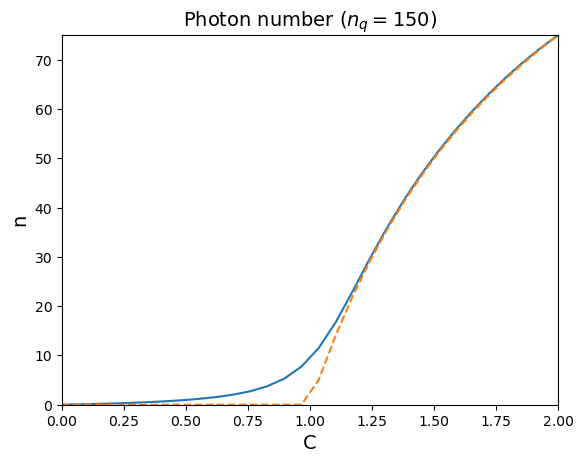

In [5]:
plt.plot(C,n_a)
plt.plot(C,np.heaviside(C-1,0)*n_q*(1-1/C),'--')
plt.xlim([np.min(C),np.max(C)])
plt.ylim([np.min(n_a),np.max(n_a)])
plt.title('Photon number ($n_q=$'+str(n_q)+')',fontsize=14)
plt.xlabel('C',fontsize=14)
plt.ylabel('n',fontsize=14)

In [6]:
wig_xvec = np.linspace(-19,19,150)
wig_pvec = np.linspace(-19,19,150)
Wigner = wigner(result[29].ptrace(0),wig_xvec,wig_pvec)

In [7]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['cmr10']
mpl.rcParams['mathtext.fontset'] = 'cm'  # Use matching math font
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 16
mpl.rc('axes', unicode_minus=False)

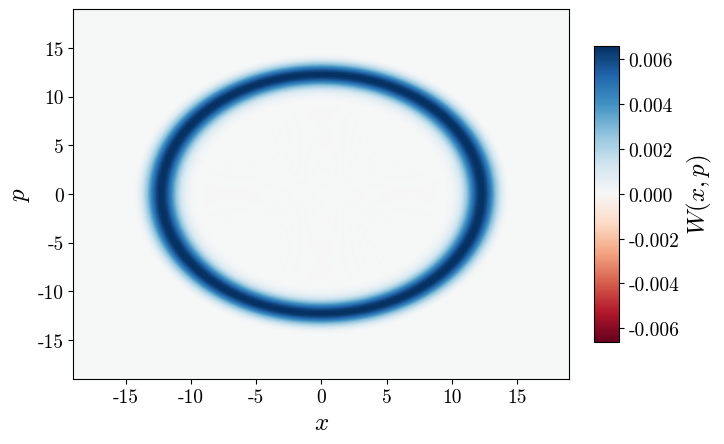

In [8]:
fig, ax = plt.subplots()
nrm = mpl.colors.Normalize(-Wigner.max(),Wigner.max())
cbar = fig.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.RdBu),cax = ax.inset_axes([1.05, 0.1, 0.05, 0.8]))
cbar.set_label('$W(x,p)$')
ax.contourf(wig_xvec, wig_pvec, Wigner, 100, cmap=cm.RdBu, norm=nrm)
plt.xlim([np.min(wig_xvec),np.max(wig_xvec)])
plt.ylim([np.min(wig_pvec),np.max(wig_pvec)])
# plt.title('Steady state Wigner function',fontsize=14)
plt.xlabel('$x$')
plt.ylabel('$p$')
fig.savefig('Wigner_laser.png',dpi=500, bbox_inches = 'tight')

In [9]:
tvec = np.linspace(0,100/k[np.size(k)-1],1000)
corr = correlation_2op_1t(H, None, tvec, [coll1,coll2], a.dag(), a)
wlist, spec = spectrum_correlation_fft(tvec,corr)

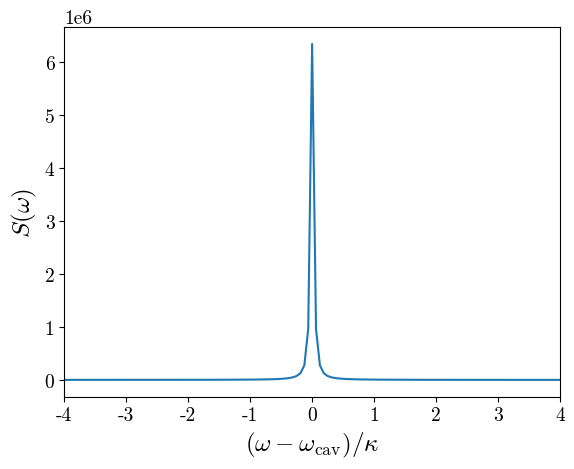

In [10]:
fig1,ax1 = plt.subplots()
ax1.plot(wlist/k[np.size(k)-1],np.real(spec))
#plt.title('freq. spectrum',fontsize=14)
plt.xlabel(r'$(\omega-\omega_\text{cav})/\kappa$')
plt.ylabel('$S(\omega)$')
plt.xlim([-4,4])
fig1.savefig('Emission_laser.png',dpi=500, bbox_inches = 'tight')

In [10]:
corr2 = correlation_3op_1t(H, None, tvec, [coll1,coll2], a.dag(), a.dag()*a, a)
n = mesolve(H, result[np.size(C)-1], tvec, [coll1,coll2], [a.dag()*a]).expect[0]
corr_2f = corr2/(n[0]*n[np.size(tvec)-1])

c:\Users\rodri\anaconda3\envs\myenv\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\rodri\anaconda3\envs\myenv\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Second order coherence function')

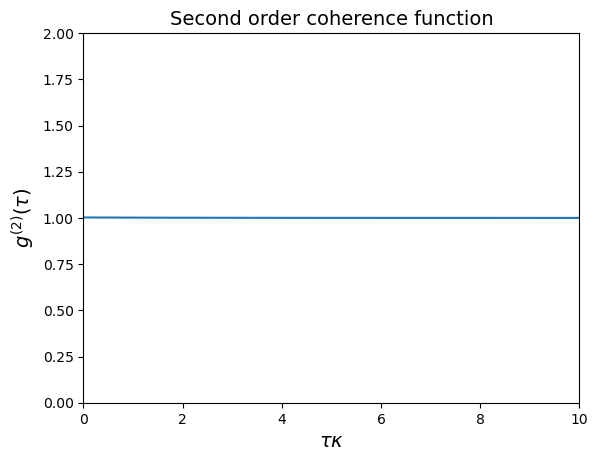

In [11]:
plt.plot(tvec*k[np.size(k)-1],corr_2f)
plt.ylim([0,2])
plt.xlim(min(tvec*k[np.size(k)-1]),max(tvec*k[np.size(k)-1]))
plt.xlabel(r'$\tau\kappa$',fontsize=14)
plt.ylabel(r'$g^{(2)}(\tau)$',fontsize=14)
plt.title('Second order coherence function',fontsize=14)